In [64]:
# features
# Name: name_length
# cabin: has_cabin
# FamilySize= SibSp + Parch、IsAlone
# Embarked.fillna('S') \ mapping 1 2 3 4
# Fare.fillna(median)
# CategoticalFare = 'Fare'.qcut()
# 'Age'.fillna(random(mean,std))、CategoticalAge、different range
# Title split： name.replace \ mapping
# Sex: 0 1
# Fare mapping  different range
#
# drop feature [paid,name,Ticket,Cabin,SibSp]

'''
Feature exacutor 
Reference from https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python/notebook
'''
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [97]:
root_path = '/home/wanghuiqin/workspace/data/Titanic/'
train_data = pd.read_csv(root_path+"train.csv")
test_data = pd.read_csv(root_path+'test.csv')
full_data = pd.concat([train_data,test_data])

# Cabin
full_data['Has_Cabin'] = full_data['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

# SibSp
full_data['FamilySize'] = full_data['SibSp'] + full_data['Parch'] + 1
full_data['IsAlone'] = 0
full_data.loc[full_data['FamilySize'] == 1, 'IsAlone'] = 1

# Embarked
full_data['Embarked'] = full_data['Embarked'].fillna('S') # full_data.Embarked.dropna().mode().values
# full_data.loc[full_data['Embarked']==nan,'Embarked'] = 'S'
full_data['Embarked'] = full_data['Embarked'].map({"S":0, 'C': 1, 'Q': 2}).astype(int)


# Fare
full_data['Fare'] = full_data['Fare'].fillna(full_data['Fare'].median())
full_data['Fare_bin'] = pd.qcut(full_data['Fare'],4)
full_data['Fare_bin'] = pd.Categorical(full_data['Fare_bin']).labels

# Age
age_avg = full_data['Age'].mean()
age_std = full_data['Age'].std()
age_null = full_data['Age'].isnull().sum()
age_random = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null)
full_data.loc[np.isnan(full_data['Age']),'Age'] = age_random
full_data['Age'] = full_data['Age'].astype(int)
full_data['Age_bin'] = pd.qcut(full_data['Age'],5)
full_data['Age_bin'] = pd.Categorical(full_data['Age_bin']).labels

# Name
full_data['Name_length'] = full_data['Name'].apply(len)
def get_title(title):
    match = re.compile(" ([A-Za-z]+)").search(title)
    if match:
        return match.group()
    else:
        return ""
    
full_data['Title'] = full_data['Name'].apply(get_title)

full_data['Title']= full_data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
full_data['Title'] = full_data['Title'].str.replace('Mlle', 'Miss')
full_data['Title'] = full_data['Title'].str.replace('Ms', 'Miss')
full_data['Title'] = full_data['Title'].str.replace('Mme', 'Mrs')
title_map = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
full_data['Title'] = pd.Categorical(full_data['Title']).labels

# Sex
full_data['Sex'] = full_data['Sex'].map({'female': 0, 'male': 1}).astype(int)

print(full_data[:5])
print(full_data.columns)
print(full_data['Age_bin'].unique())
print(full_data['Title'].unique())

   Age Cabin  Embarked     Fare  \
0   22   NaN         0   7.2500   
1   38   C85         1  71.2833   
2   26   NaN         0   7.9250   
3   35  C123         0  53.1000   
4   35   NaN         0   8.0500   

                                                Name  Parch  PassengerId  \
0                            Braund, Mr. Owen Harris      0            1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...      0            2   
2                             Heikkinen, Miss. Laina      0            3   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)      0            4   
4                           Allen, Mr. William Henry      0            5   

   Pclass  Sex  SibSp  Survived            Ticket  Has_Cabin  FamilySize  \
0       3    1      1       0.0         A/5 21171          0           2   
1       1    0      1       1.0          PC 17599          1           2   
2       3    0      0       1.0  STON/O2. 3101282          0           1   
3       1    0      1       

In [109]:
# feature selection
train_data = full_data[:train_data.shape[0]]
test_data = full_data[train_data.shape[0]:]

drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp','Age','Fare']
train_data = train_data.drop(drop_elements,axis=1)
test_data = test_data.drop(drop_elements,axis=1)
print(train_data[:5])
print(test_data[:5])



   Embarked  Parch  Pclass  Sex  Survived  Has_Cabin  FamilySize  IsAlone  \
0         0      0       3    1       0.0          0           2        0   
1         1      0       1    0       1.0          1           2        0   
2         0      0       3    0       1.0          0           1        1   
3         0      0       1    0       1.0          1           2        0   
4         0      0       3    1       0.0          0           1        1   

   Fare_bin  Age_bin  Name_length  Title  
0         0        1           23     17  
1         3        3           51     18  
2         1        2           22     16  
3         3        3           44     18  
4         1        3           24     17  
   Embarked  Parch  Pclass  Sex  Survived  Has_Cabin  FamilySize  IsAlone  \
0         2      0       3    1       NaN          0           1        1   
1         0      0       3    0       NaN          0           2        0   
2         2      0       2    1       NaN       

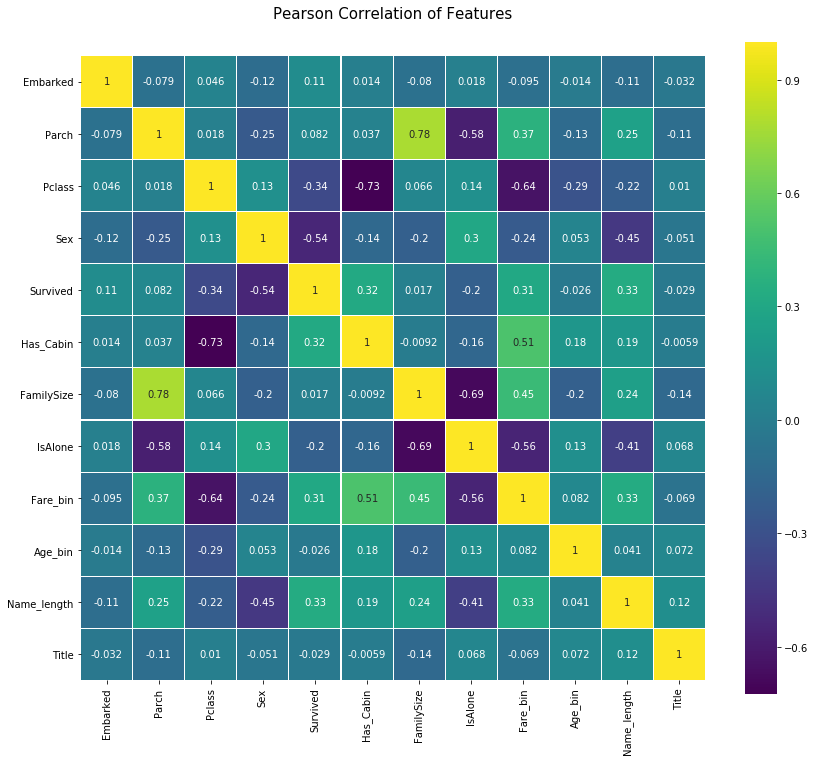

In [110]:
# pearson correlatioon heatmap
colormap = plt.cm.viridis
plt.figure(figsize=(14,12))
plt.title("Pearson Correlation of Features", y=1.05, size=15)
sns.heatmap(train_data.astype(float).corr(),linewidth=0.1, vmax=1.0, square=True,cmap=colormap, linecolor='white', annot=True)
plt.show()